## 1. 사용할 패키지 불러오기

In [103]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## 2. 데이터 불러오기

In [4]:
data = pd.read_excel('600_casecontrol.xlsx')
data.head()

,sex,Rituximab_first_date,"Disease course\n(Newly diagnosed\n,Relapsed/refractory)",B symptoms,Bulky lesion,lesion size>10(수술전후 무관),Bone marrow involvement,Number of extranodal site,Radiation therapy,Prior chemotherapy,...,AST,PLT,BUN,투약 시작 속도\ncc/hr,발생시기\n(hr),IRR 발생시 투약 속도,약물과민반응,IRR Severity (CTCAE term ver 5.0),Brown staging system,IRR 발생여부
0,M,2015-10-31,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,25.0,183,14.0,50.0,0.0,0,0,0,0,0
1,F,2017-05-16,1.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,...,18.0,275,14.0,50.0,0.0,0,0,0,0,0
2,M,2015-04-29,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,...,27.0,342,13.0,NaN,0.0,0,0,0,0,0
3,F,2010-11-15,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,21.0,222,9.0,50.0,0.0,0,0,0,0,0
4,M,2019-04-04,1.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,...,23.0,242,33.0,50.0,0.0,0,0,0,0,0


## 3. 데이터 전처리

### (1) 사용할 변수 선택

In [12]:
independent_variable = ['sex', 'B symptoms', 'Bulky lesion', 'Bone marrow involvement', '\nDiagnosis', 'Allergy\n_drug', 'Allergy\n_env,food', 'skin disease', 'Allergic rhinitis', 'Asthma', 'Atopic disesase', 'age', 'Creatinine', 'Lymphocyte', 'WBC', 'BUN']
target_variable = ['IRR 발생여부']

In [23]:
X = data.loc[:, independent_variable]
X.columns = ['sex', 'B_symptoms', 'Bulky_lesion', 'Bone_marrow_involvement', 'Diagnosis', 'Allergy_drug', 'Allergy_env_food', 'skin_disease', 'Allergic_rhinitis', 'Asthma', 'Atopic_disesase', 'age', 'Creatinine', 'Lymphocyte', 'WBC', 'BUN']
y = data[target_variable]

### (2) Allergy 변수 생성

In [30]:
Allergy = X.loc[:, ['Allergy_drug', 'Allergy_env_food', 'skin_disease', 'Allergic_rhinitis', 'Asthma', 'Atopic_disesase']]
Allergy['Allergy'] = Allergy.sum(axis=1)
Allergy['Allergy'][Allergy['Allergy'] > 0] = 1
X['Allergy'] = Allergy['Allergy']

In [31]:
del X['Allergy_drug']
del X['Allergy_env_food']
del X['skin_disease']
del X['Allergic_rhinitis']
del X['Asthma']
del X['Atopic_disesase']


### (3) 결측치 처리

In [34]:
X.isna().sum()

sex                          0
B_symptoms                 211
Bulky_lesion               317
Bone_marrow_involvement     50
Diagnosis                    0
age                          0
Creatinine                   1
Lymphocyte                   1
WBC                          0
BUN                          6
Allergy                      0
dtype: int64

#### - 범주형: 최빈값

In [41]:
Categorical_variable = ['B_symptoms', 'Bulky_lesion', 'Bone_marrow_involvement', 'Diagnosis', 'Allergy']

In [50]:
for cat_var in Categorical_variable:
    most_common = Counter(X[cat_var][-(X[cat_var].isna())]).most_common(1)[0][0]
    X[cat_var][X[cat_var].isna()] = most_common

/tmp/ipykernel_3808/2422613706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_var][X[cat_var].isna()] = most_common


#### - 연속형: 중앙값

In [52]:
Numeric_variable = ['age', 'Creatinine', 'Lymphocyte', 'WBC', 'BUN']

In [58]:
for num_var in Numeric_variable:
    median_value = np.median(X[num_var][-X[num_var].isna()])
    X[num_var][X[num_var].isna()] = median_value

/tmp/ipykernel_3808/1566572905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_var][X[num_var].isna()] = median_value


#### - 전처리 결과 확인

In [59]:
X.isna().sum()

sex                        0
B_symptoms                 0
Bulky_lesion               0
Bone_marrow_involvement    0
Diagnosis                  0
age                        0
Creatinine                 0
Lymphocyte                 0
WBC                        0
BUN                        0
Allergy                    0
dtype: int64

### (4) 연속형 변수 정규화 (Min-max 정규화)

In [60]:
minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit_transform(X.loc[:, Numeric_variable])
X.loc[:, Numeric_variable] = minmax_scaler
X.head()

,sex,B_symptoms,Bulky_lesion,Bone_marrow_involvement,Diagnosis,age,Creatinine,Lymphocyte,WBC,BUN,Allergy
0,M,0.0,0.0,0.0,C83,0.805195,0.106481,0.191667,0.024246,0.163636,1.0
1,F,0.0,0.0,0.0,C83,0.493506,0.085648,0.362500,0.022696,0.163636,0.0
2,M,0.0,0.0,0.0,C83,0.714286,0.081019,0.330208,0.048081,0.145455,1.0
3,F,0.0,0.0,0.0,C83,0.519481,0.078704,0.306250,0.018002,0.072727,0.0
4,M,0.0,0.0,1.0,C83,0.740260,0.252315,0.164583,0.047033,0.509091,0.0


### (5) 범주형 변수 One hot Encoding

In [61]:
X = pd.get_dummies(X)
X.head()

,B_symptoms,Bulky_lesion,Bone_marrow_involvement,age,Creatinine,Lymphocyte,WBC,BUN,Allergy,sex_F,sex_M,Diagnosis_C82,Diagnosis_C83,Diagnosis_C84,Diagnosis_C85,Diagnosis_C88,Diagnosis_C91
0,0.0,0.0,0.0,0.805195,0.106481,0.191667,0.024246,0.163636,1.0,0,1,0,1,0,0,0,0
1,0.0,0.0,0.0,0.493506,0.085648,0.362500,0.022696,0.163636,0.0,1,0,0,1,0,0,0,0
2,0.0,0.0,0.0,0.714286,0.081019,0.330208,0.048081,0.145455,1.0,0,1,0,1,0,0,0,0
3,0.0,0.0,0.0,0.519481,0.078704,0.306250,0.018002,0.072727,0.0,1,0,0,1,0,0,0,0
4,0.0,0.0,1.0,0.740260,0.252315,0.164583,0.047033,0.509091,0.0,0,1,0,1,0,0,0,0


### (6) Train, Test 분할 (8:2)

In [62]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=17)

## 4. 머신러닝 모델

#### - Train Dataset에서 K fold cross validation과 Grid Search를 통한 최적의 하이퍼 파라미터 선정 

In [68]:
def find_best_hyperparameter(model, params, K):
    # Make K-folds dataset
    kfold = StratifiedKFold(n_splits = K, shuffle = True, random_state = 1004)
    
    # Make Grid Search
    grid = GridSearchCV(model, params, cv = kfold)

    # Conduct Hyperparameter Search
    grid.fit(train_X, train_y)
    best_params = grid.best_params_
    best_score = grid.best_score_

    # Print Result
    print("Best Hyper Parameter: {}".format(best_params))
    print("Best Score: {}".format(best_score))

    return best_params

#### - 모델 성능 평가 (Accuracy, Precision, Recall, F1 Score, ROC_AUC)

In [125]:
Accuracy_list = []
Precision_list = []
Recall_list = []
F1_score_list = []
ROC_AUC_list = []
fpr_list = []
tpr_list = []

def Performance_report(model):
    test_predict = model.predict(test_X)
    
    accuracy = round(accuracy_score(test_y, test_predict), 2)
    precision = round(precision_score(test_y, test_predict), 2)
    recall = round(recall_score(test_y, test_predict), 2)
    f1 = round(f1_score(test_y, test_predict), 2)
    fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_X)[:, 1])
    roc_auc = round(roc_auc_score(test_y, model.predict_proba(test_X)[:, 1]), 2)

    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 score: {}".format(f1))
    print("ROC AUC: {}".format(roc_auc))
    

    Accuracy_list.append(accuracy)
    Precision_list.append(precision)
    Recall_list.append(recall)
    F1_score_list.append(f1)
    ROC_AUC_list.append(roc_auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    


### (1) Logistic Regression

In [75]:
lr_model = LogisticRegression()
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.1, 1, 10]}
best_params = find_best_hyperparameter(lr_model, params, 5)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConve

Best Hyper Parameter: {'C': 0.1, 'penalty': 'none'}
Best Score: 0.6916666666666667


/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

In [83]:
lr_model = LogisticRegression()
lr_model.set_params(**best_params).fit(train_X, train_y)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, penalty='none')

In [126]:
Performance_report(lr_model)

Accuracy: 0.58
Precision: 0.59
Recall: 0.59
F1 score: 0.59
ROC AUC: 0.65


### (2) Decision Tree

In [89]:
dt_model = DecisionTreeClassifier()
params = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split': [5, 7, 9, 11, 13]}
best_params = find_best_hyperparameter(dt_model, params, 5)

Best Hyper Parameter: {'max_depth': 3, 'min_samples_split': 5}
Best Score: 0.6


In [90]:
dt_model = DecisionTreeClassifier()
dt_model.set_params(**best_params).fit(train_X, train_y)

DecisionTreeClassifier(max_depth=3, min_samples_split=5)

In [129]:
Performance_report(dt_model)

Accuracy: 0.57
Precision: 0.59
Recall: 0.54
F1 score: 0.56
ROC AUC: 0.59


### (3) SVM

In [93]:
svm_model = SVC(probability=True)
params = {'kernel': ['linear', 'rbf', 'poly'], 'C': [1, 10, 100]}
best_params = find_best_hyperparameter(svm_model, params, 5)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConve

Best Hyper Parameter: {'C': 100, 'kernel': 'linear'}
Best Score: 0.6895833333333333


In [94]:
svm_model = SVC(probability=True)
svm_model.set_params(**best_params).fit(train_X, train_y)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=100, kernel='linear', probability=True)

In [130]:
Performance_report(svm_model)

Accuracy: 0.62
Precision: 0.64
Recall: 0.56
F1 score: 0.6
ROC AUC: 0.64


### (4) Random Forest

In [96]:
rf_model = RandomForestClassifier()
params = {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7], 'min_samples_split': [5, 7, 9]}
best_params = find_best_hyperparameter(rf_model, params, 5)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/jongwook95.lee/miniforge3/envs/ml_env

Best Hyper Parameter: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.6625000000000001


In [97]:
rf_model = RandomForestClassifier()
rf_model.set_params(**best_params).fit(train_X, train_y)

/tmp/ipykernel_3808/233259897.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.set_params(**best_params).fit(train_X, train_y)


RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=300)

In [131]:
Performance_report(rf_model)

Accuracy: 0.57
Precision: 0.57
Recall: 0.57
F1 score: 0.57
ROC AUC: 0.66


### (5) MLP

In [100]:
mlp_model = MLPClassifier()
params = {'hidden_layer_sizes': [(64,), (64, 128)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001], 'learning_rate_init': [0.001, 0.01, 0.1]}
best_params = find_best_hyperparameter(mlp_model, params, 5)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_

Best Hyper Parameter: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 128), 'learning_rate_init': 0.001}
Best Score: 0.6916666666666667


In [101]:
mlp_model = MLPClassifier()
mlp_model.set_params(**best_params).fit(train_X, train_y)

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='tanh', hidden_layer_sizes=(64, 128))

In [132]:
Performance_report(mlp_model)

Accuracy: 0.6
Precision: 0.62
Recall: 0.56
F1 score: 0.59
ROC AUC: 0.64


### (6) XGBoost

In [69]:
xgb_model = xgboost.XGBClassifier(booster = 'gbtree', objective = 'binary:logistic')
params = {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 300, 500], 'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
best_params = find_best_hyperparameter(xgb_model, params, 5)

KeyboardInterrupt: 

In [ ]:
xgb_model = xgboost.XGBClassifier(booster = 'gbtree', objective = 'binary:logistic')
xgb_model.set_params(**best_params).fit(train_X, train_y)

In [133]:
Performance_report(xgb_model)

Accuracy: 0.58
Precision: 0.6
Recall: 0.54
F1 score: 0.57
ROC AUC: 0.59


## 5. 최종 성능 평가

#### - Performance Table

In [134]:
Models = ['Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest', 'MLP', 'XGBoost']
final_result = pd.DataFrame({'Model': Models, 'Accuracy': Accuracy_list , 'Precision': Precision_list, 'Recall': Recall_list,'F1 score': F1_score_list, 'AUC': ROC_AUC_list})
final_result

,Model,Accuracy,Precision,Recall,F1 score,AUC
0,Logistic Regression,0.58,0.59,0.59,0.59,0.65
1,Decision Tree,0.57,0.59,0.54,0.56,0.59
2,SVM,0.62,0.64,0.56,0.60,0.64
3,Random Forest,0.57,0.57,0.57,0.57,0.66
4,MLP,0.60,0.62,0.56,0.59,0.64
5,XGBoost,0.58,0.60,0.54,0.57,0.59


#### - ROC Curve

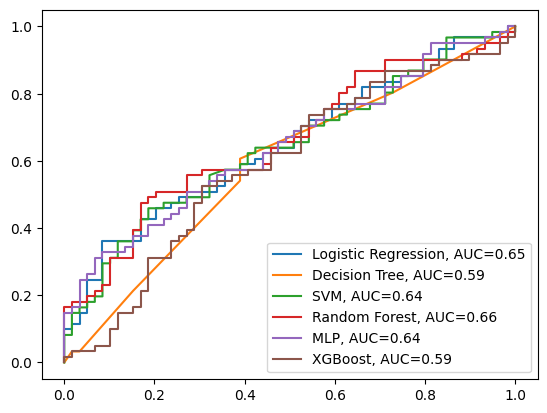

In [139]:
plt.plot(fpr_list[0],tpr_list[0],label= Models[0] + ", AUC="+str(ROC_AUC_list[0]))
plt.plot(fpr_list[1],tpr_list[1],label= Models[1] + ", AUC="+str(ROC_AUC_list[1]))
plt.plot(fpr_list[2],tpr_list[2],label= Models[2] + ", AUC="+str(ROC_AUC_list[2]))
plt.plot(fpr_list[3],tpr_list[3],label= Models[3] + ", AUC="+str(ROC_AUC_list[3]))
plt.plot(fpr_list[4],tpr_list[4],label= Models[4] + ", AUC="+str(ROC_AUC_list[4]))
plt.plot(fpr_list[5],tpr_list[5],label= Models[5] + ", AUC="+str(ROC_AUC_list[5]))
plt.legend()